## Detectron2 Model Training

# Setup Cuda for Training

In [1]:
import torch, detectron2
import torchvision

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("detectron2:", detectron2.__version__)
print("CUDNN version: ",torch.backends.cudnn.version())
# torch.cuda.empty_cache()


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.3 ; cuda:  cu118
Torch version: 2.3.1+cu118
Torchvision version: 0.18.1+cu118
detectron2: 0.6
CUDNN version:  8700


# Import Necessary Libraries

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.modeling import build_model
from detectron2.data.datasets import register_coco_instances
import matplotlib.pyplot as plt 


# Initial And Register Dataset

In [4]:
image_folder = './combine_dataset/final_dataset/train/images'
val_folder = './combine_dataset/final_dataset/val/images'
test_folder =  './combine_dataset/final_dataset/test/images'

train_json = "./instance_coco_annotations_train.json"
val_json = "./instance_coco_annotations_val.json" 
test_json = "./instance_coco_annotations_test.json" 

In [5]:
register_coco_instances("terrain_train", {}, train_json, image_folder)
register_coco_instances("terrain_val", {}, val_json,val_folder)
custom_train_metadata = MetadataCatalog.get("terrain_train").set(thing_classes=["sky","ridge","soil","sand","bedrock","rock","rover","trace","hole"])
custom_val_metadata = MetadataCatalog.get("terrain_val").set(thing_classes=["sky","ridge","soil","sand","bedrock","rock","rover","trace","hole"])

In [6]:
print(custom_val_metadata)
dataset_dicts = DatasetCatalog.get('terrain_train')

Metadata(name='terrain_val', json_file='./instance_coco_annotations_val.json', image_root='./combine_dataset/final_dataset/val/images', evaluator_type='coco', thing_classes=['sky', 'ridge', 'soil', 'sand', 'bedrock', 'rock', 'rover', 'trace', 'hole'])
[06/17 16:18:01 d2.data.datasets.coco]: Loading ./instance_coco_annotations_train.json takes 7.30 seconds.
[06/17 16:18:01 d2.data.datasets.coco]: Loaded 11319 images in COCO format from ./instance_coco_annotations_train.json


# Visualize Training Data

In [7]:
# for d in random.sample(dataset_dicts, 1):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=custom_val_metadata, scale=1.0)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1]) 
#     plt.show() 

# Initialize Configuration Variables and Hyperparameters

In [8]:
output_path = "./output2/mask_rcnn_R_50_FPN_3x/model7"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.merge_from_file("config.yaml")

cfg.DATASETS.TRAIN = ("terrain_train",)
cfg.DATASETS.TEST = ('terrain_val',)
# cfg.DATALOADER.NUM_WORKERS = 10
cfg.MODEL.WEIGHTS =  "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"

# cfg.MODEL.WEIGHTS = ""
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9
# cfg.SOLVER.IMS_PER_BATCH = 20  
# cfg.SOLVER.GAMMA = 0.001
cfg.SOLVER.BASE_LR = 0.0025
# cfg.SOLVER.STEPS = (3000, 5000,8000)
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.CHECKPOINT_PERIOD = 300
cfg.OUTPUT_DIR = output_path
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # RoI batch size

cfg.MODEL.ROI_HEADS.SMOOTH_L1_BETA: 0.001
# cfg.SOLVER.WEIGHT_DECAY = 0.01 
cfg.INPUT.MIN_SIZE_TRAIN = (200,)
cfg.INPUT.MAX_SIZE_TRAIN = 1500
cfg.INPUT.MIN_SIZE_TEST = 200
cfg.INPUT.MAX_SIZE_TEST = 1500
cfg.SOLVER.LOG_PERIOD = 500
cfg.SOLVER.MOMENTUM = 0.80
cfg.SOLVER.WARMUP_ITERS = 500

# cfg.SOLVER.NESTEROV: False
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # Adjust detection threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TRAIN = 0.9  # Adjust detection threshold during training


In [9]:
import yaml
config_file_path = output_path+"/config.yaml"

# Convert the cfg object to a dictionary
config_dict = cfg.dump()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# Save the config dictionary to a YAML file
with open(config_file_path, "w") as f:
    yaml.dump(config_dict, f)

# Train the model

In [10]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/17 16:18:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (36, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (9, 256, 1, 1

[06/17 16:18:28 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\jhanv\anaconda3\envs\det2\lib\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/17 16:18:47 d2.utils.events]:  eta: 0:56:46  iter: 19  total_loss: 7.178  loss_cls: 1.832  loss_box_reg: 0.8041  loss_mask: 0.6909  loss_rpn_cls: 3.114  loss_rpn_loc: 0.6891    time: 0.6792  last_time: 0.5908  data_time: 0.2653  last_data_time: 0.0527   lr: 9.7405e-05  max_mem: 2823M
[06/17 16:19:00 d2.utils.events]:  eta: 0:53:34  iter: 39  total_loss: 3.427  loss_cls: 0.8886  loss_box_reg: 0.3835  loss_mask: 0.6835  loss_rpn_cls: 0.6661  loss_rpn_loc: 0.7363    time: 0.6486  last_time: 0.4633  data_time: 0.1073  last_data_time: 0.0024   lr: 0.0001973  max_mem: 2823M
[06/17 16:19:12 d2.utils.events]:  eta: 0:51:56  iter: 59  total_loss: 2.819  loss_cls: 0.4785  loss_box_reg: 0.3327  loss_mask: 0.6564  loss_rpn_cls: 0.4406  loss_rpn_loc: 0.7317    time: 0.6350  last_time: 0.5632  data_time: 0.1122  last_data_time: 0.0027   lr: 0.0002972  max_mem: 2823M
[06/17 16:19:25 d2.utils.events]:  eta: 0:51:57  iter: 79  total_loss: 2.454  loss_cls: 0.4739  loss_box_reg: 0.405  loss_mask: 0.6

# Evaluate On Validation Dataset

In [11]:
# cfg.MODEL.DEVICE = "cpu"
# output_path = "./output2/mask_rcnn_R_50_FPN_3x/model4"
# cfg = get_cfg()
# cfg.DATASETS.TEST = ('terrain_val',)

evaluator = COCOEvaluator("terrain_val", cfg, False, output_dir=output_path+"/val/")
val_loader = build_detection_test_loader(cfg, "terrain_val")
results = inference_on_dataset(trainer.model, val_loader, evaluator)
with open(output_path+"/val/"+"evaluation_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Evaluation metrics saved to evaluation_results.json")

[06/17 17:23:33 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/17 17:23:33 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/17 17:23:34 d2.data.datasets.coco]: Loading ./instance_coco_annotations_val.json takes 1.08 seconds.
[06/17 17:23:34 d2.data.datasets.coco]: Loaded 1801 images in COCO format from ./instance_coco_annotations_val.json
[06/17 17:23:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(200, 200), max_size=1500, sample_style='choice')]
[06/17 17:23:34 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/17 17:23:34 d2.data.common]: Serializing 1801 elements to byte tensors and concatenating them all ...
[06/17 17:23:35 d2.data.common]: Serialized dataset takes 13.66 MiB
[06/17 17:23:35 d2.evalua

# Evaluate On Test Dataset 

In [12]:
test_folder = './combine_dataset/final_dataset/test/images'
test_json = "./instance_coco_annotations_test.json"
register_coco_instances("terrain_test", {}, test_json, test_folder)
custom_val_metadata = MetadataCatalog.get("terrain_test").set(thing_classes=["sky","ridge","soil","sand","bedrock","rock","rover","trace","hole"])


In [13]:
output_path = "./output2/mask_rcnn_R_50_FPN_3x/model7"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = output_path
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9
cfg.INPUT.MIN_SIZE_TEST = 200
cfg.INPUT.MAX_SIZE_TEST = 1500
cfg.DATASETS.TEST = ("terrain_test",)
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("terrain_test",cfg,False, output_dir=cfg.OUTPUT_DIR+"/test/")
val_loader = build_detection_test_loader(cfg, "terrain_test")
inference_results = inference_on_dataset(predictor.model, val_loader, evaluator)
with open(output_path+"/test/"+"evaluation_results.json", "w") as f:
    json.dump(inference_results, f, indent=4)

[06/18 10:05:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output2/mask_rcnn_R_50_FPN_3x/model7\model_final.pth ...
[06/18 10:05:02 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
WARNING [06/18 10:05:02 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/18 10:05:12 d2.data.datasets.coco]: Loading ./instance_coco_annotations_test.json takes 2.94 seconds.
[06/18 10:05:12 d2.data.datasets.coco]: Loaded 1901 images in COCO format from ./instance_coco_annotations_test.json
[06/18 10:05:12 d2.data.build]: Distribution of instances among all 9 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    sky     | 155          |   ridge    | 224          |    soil    | 3712         |
|    

# Visualize Predicted output on Test Dataset

In [3]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2 import model_zoo
import torch
torch.cuda.empty_cache()
import matplotlib.pyplot as plt 
import os
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

output_path = "./output2/mask_rcnn_R_50_FPN_3x/model7"

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.OUTPUT_DIR = output_path
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 9

predictor = DefaultPredictor(cfg)

In [4]:
test_folder = './combine_dataset/final_dataset/test/images'
test_json = "./instance_coco_annotations_test.json"
register_coco_instances("terrain_test", {}, test_json, test_folder)
custom_val_metadata = MetadataCatalog.get("terrain_test").set(thing_classes=["sky","ridge","soil","sand","bedrock","rock","rover","trace","hole"])
metadata = MetadataCatalog.get('terrain_test')


yo


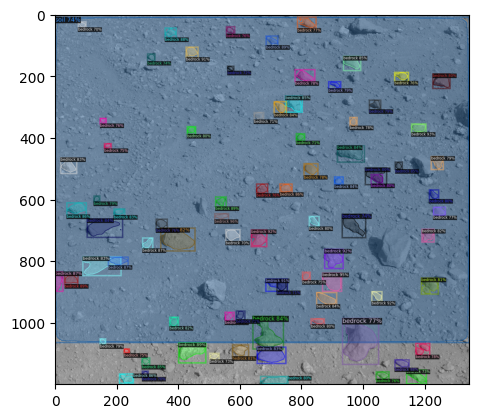

yo


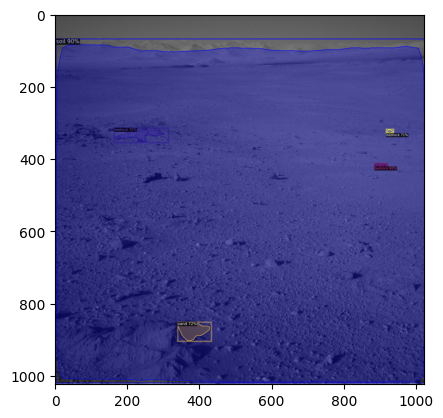

yo


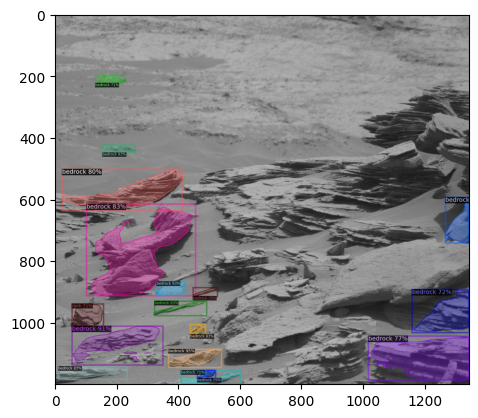

yo


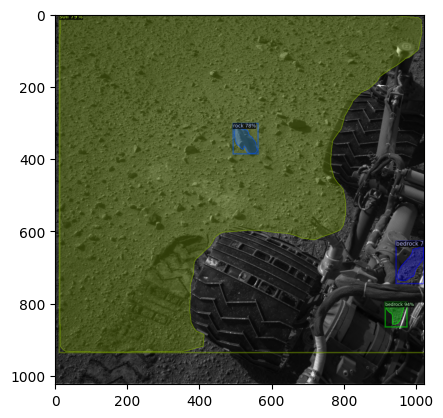

yo


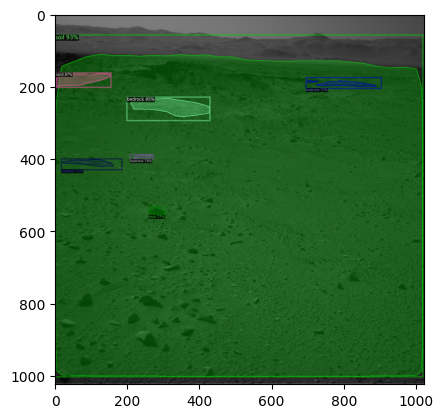

yo


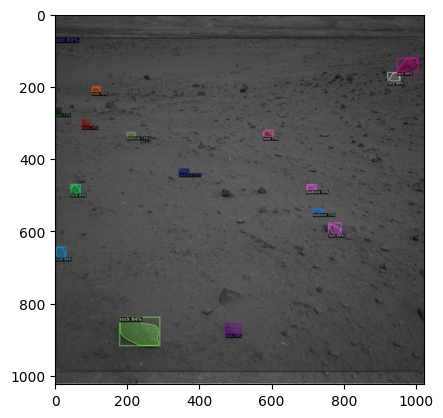

yo


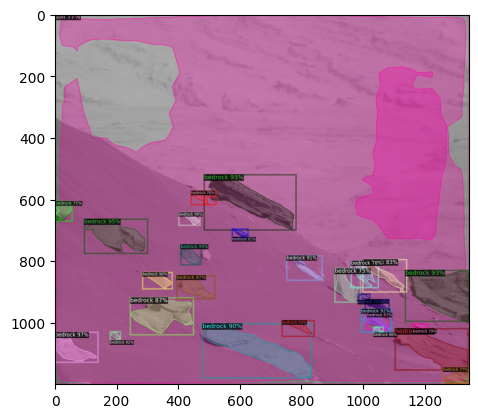

yo


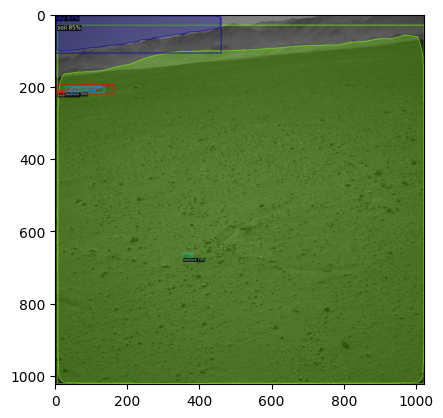

yo


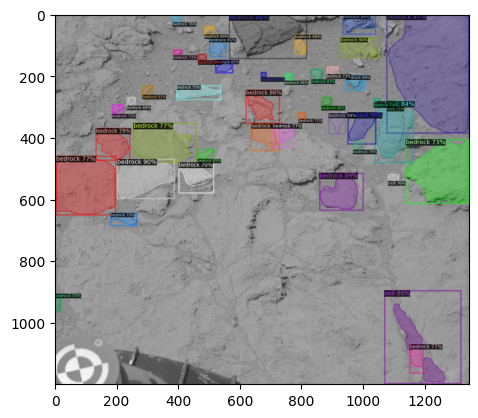

yo


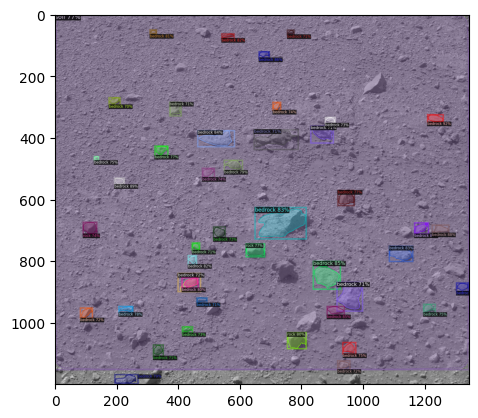

In [6]:
from detectron2.utils.visualizer import ColorMode
import random
import cv2
output_dir = output_path+"test/instance_segmentation/prediction_output"
instance_json = []
dataset_dicts = DatasetCatalog.get('terrain_test')
for d in random.sample(dataset_dicts,10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE_BW
    )
    print("yo")
    insts = outputs["instances"].to("cpu")
    out = v.draw_instance_predictions(insts)
    plt.imshow(out.get_image()[:, :, ::-1]) 
    plt.show()

In [7]:
custom_val_metadata = MetadataCatalog.get("terrain_test").set(thing_classes=["sky","ridge","soil","sand","bedrock","rock","rover","trace","hole"])
# dataset_dicts = list(train_json['images'])
dataset_dicts = DatasetCatalog.get('terrain_test')
metadata = MetadataCatalog.get('terrain_test')
output_dir = output_path+"test/instance_segmentation/prediction_output"

for d in dataset_dicts:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    vis = visualizer.draw_dataset_dict(d)
    # plt.imshow(vis.get_image()[:, :, ::-1]) 
    # plt.show()
    filename = output_dir + "/"+d["file_name"].split("\\")[-1].replace(".jpg",".png")
    cv2.imwrite(filename,vis.get_image()[:, :, ::-1])

In [3]:
import cv2
img = cv2.imread("./combine_dataset/final_dataset/test/images/0735MR0031500210403096E01_DXXX.jpg")
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
vis = visualizer.draw_dataset_dict(d)
output_dir = output_path+"test/instance_segmentation/prediction_output"
# plt.imshow(vis.get_image()[:, :, ::-1]) 
# plt.show()
# filename = "prediction_output/masks/"+ d["file_name"].split("\\")[-1].replace(".jpg",".png")
cv2.imwrite(output_dir + "/masks_0735MR0031500210403096E01_DXXX.png",vis.get_image()[:, :, ::-1])

NameError: name 'd' is not defined